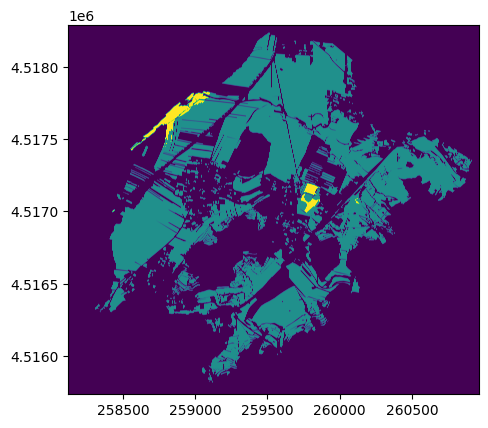

<Axes: >

In [2]:
import rasterio
from onnx.reference.ops.op_sigmoid import sigmoid
from rasterio.plot import show

standard_file_path = "../datasets/standard.tif"

# 打开tif文件
ds_standard = rasterio.open(standard_file_path)

show((ds_standard, 1))

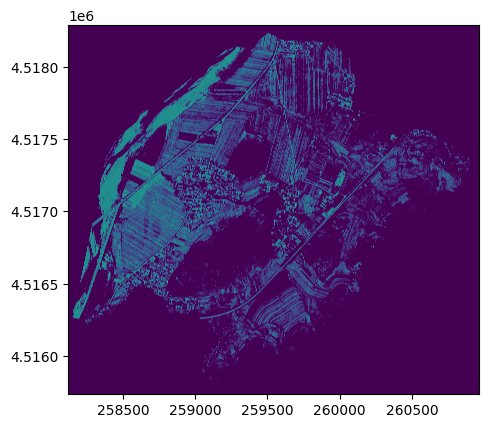

<Axes: >

In [3]:
example_file_path = "../datasets/submission_example.tif"

# 打开tif文件
ds_example = rasterio.open(example_file_path)

show((ds_example, 1))

In [3]:
standard_file_path = "../datasets/standard.tif"
result_file_path = "../datasets/main/result.tif"

In [7]:
import os
import rasterio

# 遍历根目录下的所有 tif 文件，保存它们的形状
for root, dirs, files in os.walk("../datasets"):
    for file in files:
        if file.endswith(".tif"):
            file_path = os.path.join(root, file)
            with rasterio.open(file_path) as src:
                data = src.read()
                print(f"File: {file_path}, Shape: {data.shape}")
                

File: ../datasets\standard.tif, Shape: (1, 39291, 43641)
File: ../datasets\submission_example.tif, Shape: (1, 39291, 43641)
File: ../datasets\main\dsm.tif, Shape: (1, 19631, 21804)
File: ../datasets\main\gsddsm.tif, Shape: (1, 3004, 3106)
File: ../datasets\main\result.tif, Shape: (4, 39291, 43641)
File: ../datasets\main\result_Green.tif, Shape: (1, 23127, 25687)
File: ../datasets\main\result_NIR.tif, Shape: (1, 23127, 25687)
File: ../datasets\main\result_Red.tif, Shape: (1, 23127, 25687)
File: ../datasets\main\result_RedEdge.tif, Shape: (1, 23127, 25687)


In [10]:
gsddsm_file_path = "../datasets/main/gsddsm.tif"
with rasterio.open(gsddsm_file_path) as src:
    print(src.meta)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 3106, 'height': 3004, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(1.11444032881991e-05, 0.0, 120.13365110273004,
       0.0, -7.93821087086144e-06, 40.78086412823033)}


In [11]:
gsddsm_file_path = "../datasets/main/result.tif"
with rasterio.open(gsddsm_file_path) as src:
    print(src.meta)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 43641, 'height': 39291, 'count': 4, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 51N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32651"]]'), 'transform': Affine(0.0651, 0.0, 258121.02701859066,
       0.0, -0.0651, 4518292.6701675765)}


In [11]:
import os
import rasterio
import tqdm
from PIL import Image
import numpy as np

# 定义源目录和目标目录
target_dir = r'../data'

# 定义图像块的大小和步长
block_size = 256  # 例如，每个图像块的大小为256x256
stride = 256      # 步长决定了图像块之间的重叠，这里没有重叠

# 创建目标目录结构
sub_dirs = ['train', 'val']
for sub_dir in sub_dirs:
    os.makedirs(os.path.join(target_dir, sub_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(target_dir, sub_dir, 'masks'), exist_ok=True)

# 处理tif文件
def process_tif(file_path, output_dir):
    with rasterio.open(file_path) as src:
        data = src.read()  # 读取数据
        meta = src.meta  # 获取元数据
    
    i_len = data.shape[1] // stride + (1 if data.shape[1] % stride != 0 else 0)
    j_len = data.shape[2] // stride + (1 if data.shape[2] % stride != 0 else 0)
    
    # 遍历图像数据，生成图像块
    with tqdm.tqdm(total=i_len * j_len) as pbar:
        for i in range(0, data.shape[1], stride):
            for j in range(0, data.shape[2], stride):
                # 计算图像块的实际大小，确保不会超出边界
                i_end = min(i + block_size, data.shape[1])
                j_end = min(j + block_size, data.shape[2])
    
                # 切割图像块
                block = data[:, i:i_end, j:j_end]
    
                # 如果块大小小于block_size，我们需要填充
                if block.shape[1:] != (block_size, block_size):
                    pad_height = block_size - block.shape[1]
                    pad_width = block_size - block.shape[2]
                    block = np.pad(block, ((0, 0), (0, pad_height), (0, pad_width)), mode='constant')
                    
                
                # 将 block 从 (1/4, 256, 256) 转换为 (256, 256, 1/4)
                block = np.transpose(block, (1, 2, 0))
                
                if block.shape[2] == 1:
                    block = block.squeeze()
    
                # 将numpy数组转换为PIL图像
                block_image = Image.fromarray(block)
    
    
                # 确定文件名
                file_name = f"{os.path.splitext(os.path.basename(file_path))[0]}_{i}_{j}.png"
    
                # 保存图像块
                block_image.save(os.path.join(output_dir, file_name))
                
                pbar.update(1)

# 假设第一个文件是掩码，第二个文件是图像
mask_file_path = "../datasets/standard.tif"
image_file_path = "../datasets/main/result.tif"

# 处理掩码文件
process_tif(mask_file_path, os.path.join(target_dir, 'train', 'masks'))

# 处理图像文件
process_tif(image_file_path, os.path.join(target_dir, 'train', 'images'))

print("数据集结构已生成。")


100%|██████████| 26334/26334 [06:18<00:00, 69.60it/s] 


数据集结构已生成。


In [12]:
# 从 'data/train' 目录下抽取20%的数据作为验证集
import shutil
import random
import os
from shutil import copyfile
from tqdm import tqdm
# 定义源目录和目标目录
source_dir = "../data/train"
target_dir = "../data/val"
# 创建目标目录
os.makedirs(target_dir, exist_ok=True)
# 获取源目录下的所有文件
files = os.listdir(os.path.join(source_dir, 'images'))
# 源目录和目标目录下分别有 images 和对应的 masks 文件夹，文件名分别为 result_i_j.png 和 standard_i_j.png
# 随机抽取20%的文件
num_files = len(files)
num_val_files = int(num_files * 0.05)
val_files = random.sample(files, num_val_files)


In [13]:

# 将抽取的文件复制到目标目录
for file in tqdm(val_files):
    # 复制图像文件
    copyfile(os.path.join(source_dir, 'images', file), os.path.join(target_dir, 'images', file))
    # 复制掩码文件
    copyfile(os.path.join(source_dir, 'masks', file.replace('result', 'standard')), os.path.join(target_dir, 'masks', file.replace('result', 'standard')))
    # 删除源目录下的文件
    os.remove(os.path.join(source_dir, 'images', file))
    os.remove(os.path.join(source_dir, 'masks', file.replace('result', 'standard')))

100%|██████████| 1316/1316 [00:07<00:00, 187.31it/s]


In [9]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T

class SegmentationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = os.listdir(os.path.join(root_dir, 'images'))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.root_dir, 'images', img_name)
        mask_path = os.path.join(self.root_dir, 'masks', img_name.replace('result', 'standard'))

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# 定义变换
transform = T.Compose([
    T.ToTensor(),
])

# 创建数据集
train_dataset = SegmentationDataset(root_dir='../data/train', transform=transform)
val_dataset = SegmentationDataset(root_dir='../data/val', transform=transform)

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [ ]:
import torch
from segmentation_models_pytorch import Unet

# 检查CUDA是否可用
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 创建模型
model = Unet(encoder_name='resnet34',
             encoder_weights='imagenet',
             classes=1,
             activation='sigmoid'
             ).to(device)

# 损失函数和优化器
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# 初始化最小loss为正无穷大
min_loss = float('inf')

# 训练模型
for epoch in range(1, 21):  # 20个训练周期
    model.train()
    for batch in train_loader:
        images, masks = batch
        # 将数据和模型都移动到GPU
        images = images.to(device)
        masks = masks.to(device)
        
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # 每个epoch结束时检查loss
    if loss.item() < min_loss:
        min_loss = loss.item()
        # 保存模型
        torch.save(model.state_dict(), '../best_model.pth')
        print(f'Epoch {epoch}, Loss: {loss.item()}, New best model saved.')
    else:
        print(f'Epoch {epoch}, Loss: {loss.item()}')


In [3]:
# 加载模型，在验证集合上看 F1 Score 和准确率
from sklearn.metrics import accuracy_score, f1_score
import torch
from segmentation_models_pytorch import Unet

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Unet(encoder_name='resnet34', encoder_weights='imagenet', classes=1).to(device)
model.load_state_dict(torch.load('../best_model.pth', weights_only=True))
model.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for batch in val_loader:
        images, masks = batch
        images = images.to(device)
        masks = masks.to(device)
        
        outputs = model(images)
        outputs = torch.sigmoid(outputs)
        predicted_labels.extend(outputs.cpu().numpy().flatten())
        true_labels.extend(masks.cpu().numpy().flatten())
        break


In [4]:
del model
import gc
gc.collect()

652

In [6]:
import numpy as np

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

In [7]:
# 查看数据分布情况
min_true_labels = np.min(true_labels)
max_true_labels = np.max(true_labels)
min_predicted_labels = np.min(predicted_labels)
max_predicted_labels = np.max(predicted_labels)

print(f'True labels range: {min_true_labels} to {max_true_labels}')
print(f'Predicted labels range: {min_predicted_labels} to {max_predicted_labels}')

True labels range: 0.0 to 0.007843137718737125
Predicted labels range: 5.647906618833076e-06 to 0.021049410104751587


In [8]:
import numpy as np

true_labels = np.concatenate(true_labels)
predicted_labels = np.concatenate(predicted_labels)

accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print(f'Accuracy: {accuracy}, F1 Score: {f1}')

MemoryError: 

In [1]:
from tif2pngs import Tif2Pngs, init_data_dir, ROOT
import os

# 阶段一，处理原始 tif 文件
init_data_dir()
mask_file_path = os.path.join(ROOT, 'datasets', 'standard.tif')
image_file_path = os.path.join(ROOT, 'datasets', 'main', 'result.tif')
tif2pngs = Tif2Pngs(image_file_path, os.path.join(ROOT, 'data', 'train', 'images'))
tif2pngs.process_tif()
tif2pngs = Tif2Pngs(mask_file_path, os.path.join(ROOT, 'data', 'train', 'masks'))
tif2pngs.process_tif()
print("Done")

100%|██████████| 26334/26334 [00:19<00:00, 1335.34it/s]

Done


In [2]:
from SegmentationDataset import SegmentationDataset, split_train_val
import os
from torch.utils.data import DataLoader
from torchvision import transforms as T

# 阶段二，划分训练集和验证集
split_train_val()

train_dir = os.path.join(ROOT, 'data', 'train')
val_dir = os.path.join(ROOT, 'data', 'val')

# 定义变换
transform = T.Compose([
    T.ToTensor(),
])

# 创建数据集
train_dataset = SegmentationDataset(root_dir=train_dir, transform=transform)
val_dataset = SegmentationDataset(root_dir=val_dir, transform=transform)

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

100%|██████████| 5266/5266 [00:28<00:00, 183.27it/s]


In [4]:
import torch
from segmentation_models_pytorch import Unet

# 检查CUDA是否可用
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 创建模型
model = Unet(encoder_name='resnet34',
             encoder_weights='imagenet',
             classes=1,
             activation='sigmoid'
             ).to(device)

# 损失函数和优化器
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# 初始化最小loss为正无穷大
min_loss = float('inf')

# 训练模型
for epoch in range(1, 21):  # 20个训练周期
    model.train()
    for batch in train_loader:
        images, masks = batch
        # 将数据和模型都移动到GPU
        images = images.to(device)
        masks = masks.to(device)
        
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # 每个epoch结束时检查loss
    if loss.item() < min_loss:
        min_loss = loss.item()
        # 保存模型
        torch.save(model.state_dict(), f'../model/best_model_epoch_{epoch}.pth')
        print(f'Epoch {epoch}, Loss: {loss.item()}, New best model saved.')
    else:
        print(f'Epoch {epoch}, Loss: {loss.item()}')


Epoch 1, Loss: 0.7511634826660156, New best model saved.
Epoch 2, Loss: 0.7099115252494812, New best model saved.
Epoch 3, Loss: 0.700645387172699, New best model saved.
Epoch 4, Loss: 0.6979333758354187, New best model saved.
Epoch 5, Loss: 0.7058827877044678
Epoch 6, Loss: 0.7014686465263367
Epoch 7, Loss: 0.6946263313293457, New best model saved.
Epoch 8, Loss: 0.671099841594696, New best model saved.
Epoch 9, Loss: 0.6941342353820801
Epoch 10, Loss: 0.693839430809021
Epoch 11, Loss: 0.6943192481994629
Epoch 12, Loss: 0.6936949491500854
Epoch 13, Loss: 0.6934423446655273
Epoch 14, Loss: 0.6934718489646912
Epoch 15, Loss: 0.6935631036758423
Epoch 16, Loss: 0.6932411193847656
Epoch 17, Loss: 0.6935751438140869
Epoch 18, Loss: 0.7135591506958008
Epoch 19, Loss: 0.6932618618011475
Epoch 20, Loss: 0.6932704448699951


[0.         0.00392157 0.00784314]
118


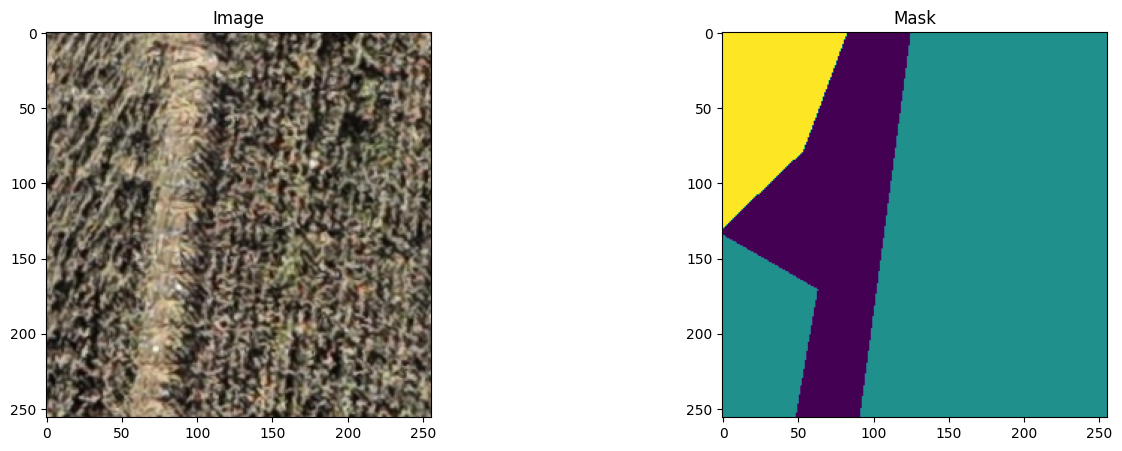

In [26]:
from matplotlib import pyplot as plt
import numpy as np

i = 0
while i < len(val_dataset):
    image, mask = val_dataset[i]
    if len(np.unique(mask)) == 3:
        print(np.unique(mask))
        print(f"{i}")
        break
    i += 1
        
# 显示图像和掩码
image = image.permute(1, 2, 0)
mask = mask.permute(1, 2, 0)
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Image')
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.title('Mask')
plt.show()

In [27]:
from sklearn.metrics import accuracy_score, f1_score
import torch
from segmentation_models_pytorch import Unet

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Unet(encoder_name='resnet34', encoder_weights='imagenet', classes=1).to(device)
model.load_state_dict(torch.load('../model/best_model_epoch_8.pth', weights_only=True))
model.eval()
pass

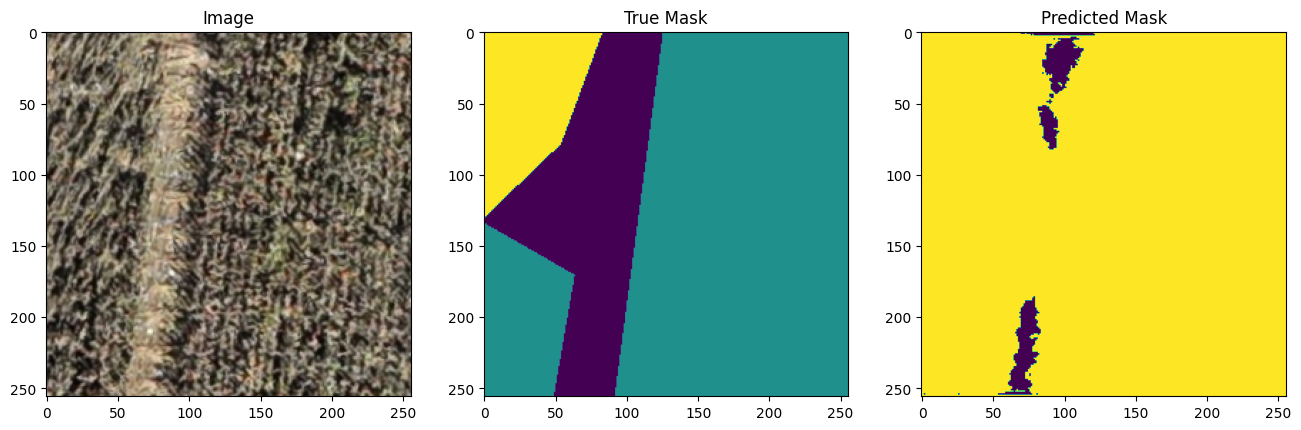

In [28]:
image1, mask1 = val_dataset[i]

# 预测
with torch.no_grad():
    image_input = image1.unsqueeze(0).to(device)
    mask1 = mask1.unsqueeze(0)
    output = model(image_input)
    output = torch.sigmoid(output)
    predicted_mask = output.squeeze().cpu().numpy()
    true_mask = mask1.squeeze().cpu().numpy()
    
# 将predicted_mask的值按照最近距离转化为 [0.         0.00392157 0.00784314]
# 遍历 predicted_mask
for i in range(predicted_mask.shape[0]):
    for j in range(predicted_mask.shape[1]):
        value = predicted_mask[i][j]
        dis = [abs(value - 0.0), abs(value - 0.00392157), abs(value - 0.00784314)]
        index = dis.index(min(dis))
        predicted_mask[i][j] = [0.0, 0.00392157, 0.00784314][index]

# 显示预测结果
plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
plt.imshow(image1.permute(1, 2, 0))
plt.title('Image')
plt.subplot(1, 3, 2)
plt.imshow(true_mask)
plt.title('True Mask')
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask)
plt.title('Predicted Mask')
plt.show()